In [305]:
#counts # of comments in a post for a givne ID

import json

def count_comments(file, uid):
    with open(file, 'r') as f:
        data = json.load(f)
        posts = data['posts']
        for post in posts:
            if post['id'] == uid:
                i = 0
                stack = []
                comments = post['comments']

                stack = comments
                while stack != []:  
                    comment = stack.pop()
                    i+=1
                    if len(comment['comments']) > 0:
                        stack = stack + comment['comments']

                return i

#count_comments('data/Dogecoin-2022-05-04-01-50-29.json', 'uhdmuq')

In [306]:
import os
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure




l = []
datafolder = '../local/2022-5-15-11-11/'
for file in os.listdir(os.path.join(datafolder)):
    if file.endswith(".json"):

        with open(datafolder+file, 'r') as f:
            data = json.load(f)
            posts = data['posts']
            s = data['subreddit']
            for post in posts:
                    i = 0
                    stack = []
                    comments = post['comments']
                    stack = comments
                    while stack != []:  
                        comment = stack.pop()
                        l.append((comment['id'], comment['author'], comment['score'], comment['created_utc'], comment['depth'],s))
                        if len(comment['comments']) > 0:
                            stack = stack + comment['comments']

df = pd.DataFrame(columns = ["id", "author", "score", "created_utc", "depth","subreddit"], data=l)
df = df.astype({'created_utc': 'int64'})
df.sort_values(by=['created_utc'], inplace=True)
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

df['date'] = df['created_utc'].dt.date

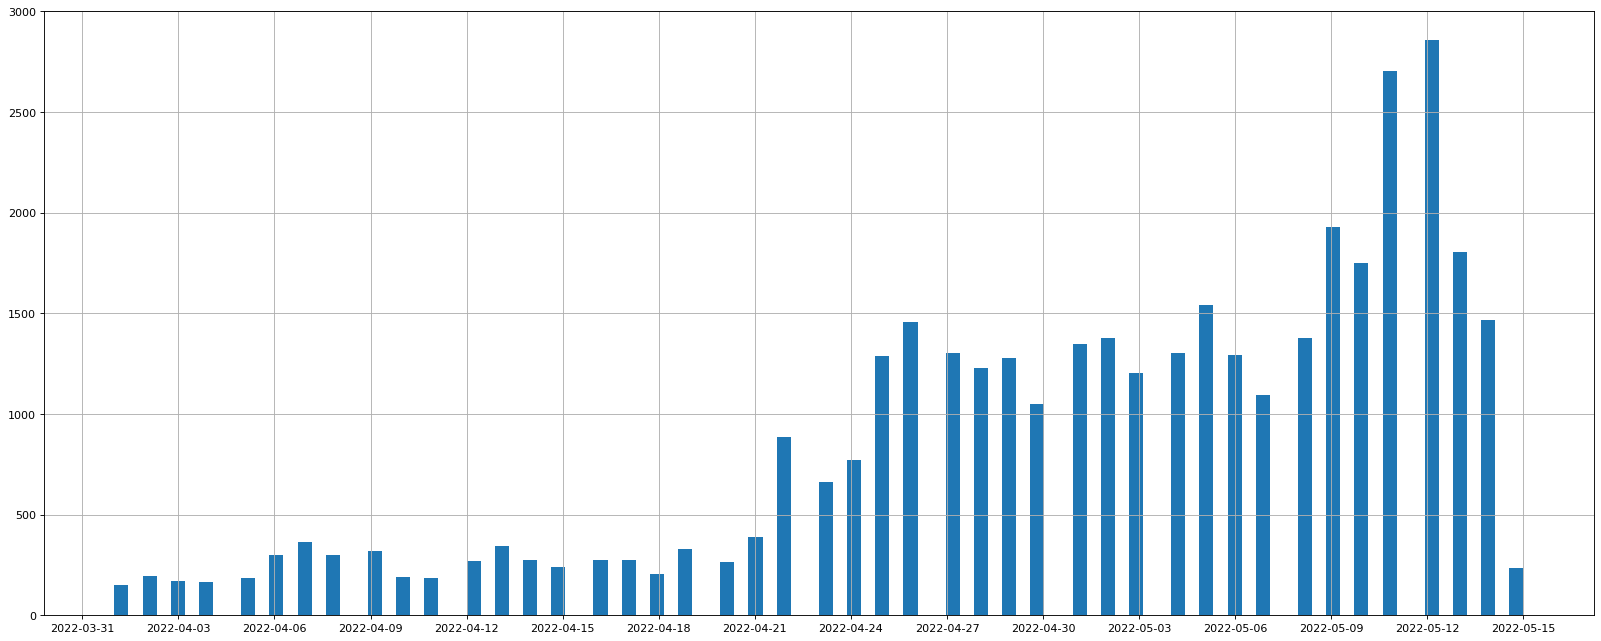

In [311]:
# dates
import matplotlib.dates as mdates
figure(figsize=(25, 10), dpi=80)
fr = pd.to_datetime("2022-4-1").date()
ax = df[(df['date'] >= fr)]['date'].hist(bins=100)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

In [312]:
ua=len(pd.unique(df['author']))
a=len(df['author'])
print(f"{ua} unique authors in {a} comments, ratio:{ua/a}")

vc = df['author'].value_counts()


print(f'users who posted more than 1 comment: {len(vc[vc>1])}')
print(f'users who posted more than 2 comments: {len(vc[vc>2])}')
print(f'users who posted more than 3 comments: {len(vc[vc>3])}')
print(f'users who posted more than 5 comments: {len(vc[vc>5])}')
print(f'users who posted more than 10 comments: {len(vc[vc>10])}')
print(f'users who posted more than 50 comments: {len(vc[vc>50])}')
print(f'users who posted more than 100 comments: {len(vc[vc>100])}')

19427 unique authors in 45709 comments, ratio:0.42501476733247284
users who posted more than 1 comment: 6697
users who posted more than 2 comments: 3643
users who posted more than 3 comments: 2307
users who posted more than 5 comments: 1255
users who posted more than 10 comments: 522
users who posted more than 50 comments: 41
users who posted more than 100 comments: 11


In [313]:
start_date = pd.to_datetime("2022-4-1").date()
after_april_2022 = df[(df['date'] >= start_date)]

print(f'ratio of posts >= 1. april 2022: {len(after_april_2022)/len(df)}')

ratio of posts >= 1. april 2022: 0.8439257039095145


In [314]:
grouped_df = df.groupby(["author"])
f=grouped_df['score'].agg('sum')
f

author
--Imposter--            5
--Slipp3ry__Snak3--    18
-Afro_Senpai-          12
-Aporia                73
-ArtDeco-               3
                       ..
zxygambler             17
zygodontfario53        19
zyppoboy                3
zyro99                  4
zzonked7               19
Name: score, Length: 19427, dtype: int64

In [315]:
f = df[["author", "subreddit"]].groupby(["author"])
f2 = f['subreddit'].apply(list)
f2

author
--Imposter--                                                   [Binance]
--Slipp3ry__Snak3--                                 [Ethereum, Ethereum]
-Afro_Senpai-                                         [BitcoinBeginners]
-Aporia                [Ethereum, Ethereum, Ethereum, Ethereum, Crypt...
-ArtDeco-                                                     [CoinBase]
                                             ...                        
zxygambler                                            [Bitcoin, Bitcoin]
zygodontfario53                           [CryptoMarkets, CryptoMarkets]
zyppoboy                                                      [Dogecoin]
zyro99                                                         [Binance]
zzonked7                                                       [Bitcoin]
Name: subreddit, Length: 19427, dtype: object

In [47]:
def jsonToEdgeList(file):
    with open(file, 'r') as f:
        subreddit = json.load(f)
        assert subreddit['subreddit'] is not None, "subreddit name cannot be None"
        assert subreddit['posts'] is not None, "subreddit name cannot be None"
        for post in subreddit['posts']:
            postToEdgeList(post, subreddit['subreddit'])

def postToEdgeList(post,subreddit):
    commentsToEdgeList(post['comments'], [(post['author'], 1)])

l = []
edges = {}
vertices = {}
    
def commentsToEdgeList(comments, context):

    for comment in comments:
        current_comment_author = comment['author']
        for prev_author, depth in context:
            if prev_author != current_comment_author: #avoid self loops
                key = (current_comment_author, prev_author)
                if key not in edges.keys():
                    edges[key] = comment['score']/depth
                else:
                    w = edges[key]
                    edges[key] = w + comment['score']/depth
        if len(comment['comments']) > 0:
            commentsToEdgeList(comment['comments'], context + [(current_comment_author, comment['score'])])
    
    
jsonToEdgeList('../data/Binance-2022-05-04-01-50-29.json')

In [397]:
import json
import os
import pandas as pd

class CSVDumper():
    def __init__(self):
        self.edges = { 'deep_link' : {}, 'next_link': {}, 'cartesian_link' : [], 'deep_link_no_merge': {} }
        self.vertices = {}
        self.data = []
        
    def parse_json_file(self, file):
        with open(file, 'r') as f:
            subreddit = json.load(f)
            assert subreddit['subreddit'] is not None, "subreddit name cannot be None"
            assert subreddit['posts'] is not None, "subreddit posts cannot be empty"

            for post in subreddit['posts']:

                self.parse_comments_pd(post, subreddit['subreddit']) #for internal pd data frame

                self.parse_comments_deep_link(post['comments'], [(post['author'], 1)], subreddit['subreddit'])
                self.parse_comments_next_link(post['comments'], [(post['author'], 1)], subreddit['subreddit'])
                self.parse_comments_ucartesian_link(post['comments'], post['author'], subreddit['subreddit'])


    def parse_comments_pd(self, post, sub):
        self.data.append((post['id'], post['author'], post['score'], post['created_utc'], 1, sub))
        self.parse_comments_pd_r(post['comments'], sub)

    def parse_comments_pd_r(self, comments, sub):
        for comment in comments:
            self.data.append((comment['id'], comment['author'], comment['score'], comment['created_utc'], comment['depth'], sub))
            if len(comment['comments']) > 0:
                self.parse_comments_pd_r(comment['comments'], sub)

    def parse_comments_deep_link(self,comments,context, sub):
        for comment in comments:
            for prev_author, depth in context:
                if prev_author != comment['author']: #avoid self loops
                    key = (comment['author'], prev_author)
                    
                    #insert/update edge
                    if key not in self.edges['deep_link'].keys():
                        self.edges['deep_link'][key] = comment['score']/depth
                    else:
                        w = self.edges['deep_link'][key]
                        self.edges['deep_link'][key] = w + comment['score']/depth
                        
            if len(comment['comments']) > 0:
                self.parse_comments_deep_link(comment['comments'], context + [(comment['author'], comment['depth'])], sub)
    
    def parse_comments_next_link(self,comments,context, sub):
        for comment in comments:
            for prev_author, depth in context:
                if prev_author != comment['author']: #avoid self loops
                    key = (comment['author'], prev_author)
                    
                    #insert/update edge
                    if key not in self.edges['next_link'].keys():
                        self.edges['next_link'][key] = comment['score']/depth
                    else:
                        w = self.edges['next_link'][key]
                        self.edges['next_link'][key] = w + comment['score']/depth
                        
            if len(comment['comments']) > 0:
                self.parse_comments_next_link(comment['comments'], [context[0],(comment['author'], comment['depth'])], sub)
    
    def parse_comments_ucartesian_link_dump(self, folder):
        f = [ (tpl[0], tpl[1], 1) for tpls in self.edges['cartesian_link'] for tpl in tpls]
        p = pd.DataFrame(data=f, columns=["node1", "node2", "weight"])

        grouped = p.groupby(["node1", "node2"])
        s = grouped['weight'].agg('sum')
        s.to_csv(f"{folder}/edges_ucartesian.csv")

    def parse_comments_ucartesian_link(self,comments,post_author, sub):

        authors = [post_author]
        stack = []
        stack = comments
        while stack != []:
            comment = stack.pop()
            authors.append(comment['author'])

            if len(comment['comments']) > 0:
                stack = stack + comment['comments']

        #build unique cartesian product
        prd = []
        for x in authors:
            for y in authors:
                if x != y:
                    tpl = tuple(sorted((x,y)))
                    if tpl not in prd:
                        prd.append(tpl)

        self.edges['cartesian_link'].append(prd)




    def parse_comments_deep_link_no_merge(self,comments,context, sub):
        for comment in comments:
            for prev_author, depth in context:
                if prev_author != comment['author']: #avoid self loops
                    key = comment['id']
                    self.edges['deep_link_no_merge'][key] = comment['score']/depth
                        
            if len(comment['comments']) > 0:
                self.parse_comments_deep_link_no_merge(comment['comments'], context + [(comment['author'], comment['depth'])], sub)
    
    def parse_folder(self, folder):
        for file in os.listdir(os.path.join(folder)):
            if file.endswith(".json"):
                self.parse_json_file(os.path.join(folder, file))

    def prep_df(self):
        df = pd.DataFrame(columns = ["id", "author", "score", "created_utc", "depth","subreddit"], data=self.data)
        df = df.astype({'created_utc': 'int64'})
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
        return df
    
    def dump_scores(self,file):
        grouped_df = self.prep_df().groupby(["author"])
        s = grouped_df['score'].agg('sum')
        s.index.names = ['Id']
        s.to_csv(file)

    def dump_active_subs(self,file):
        df = self.prep_df()
        g = df[["author", "subreddit"]].groupby(["author"])
        g = g['subreddit'].apply(list)
        g.index.names = ['Id']
        g.to_csv(file)
        
    def dump_edges(self, folder):
        l = ['next_link', 'deep_link', 'deep_link_no_merge']
        for link in l:
            file = f"{folder}/edges_{link}.csv"
            d = [ (source,target,weight) for (source,target), weight in self.edges[link].items() ]
            pd.DataFrame(columns = ["source", "target", "weight"],data=d).to_csv(file, index=False)

        #dump ucartesian
        self.parse_comments_ucartesian_link_dump(folder)
    
    def dump_gephi(self,file):
        pass

    def debug(self):
        return self.data
    
dp = CSVDumper()
dp.parse_folder('../test_data')
dp.dump_scores('../test_data/csv/scores.csv')
dp.dump_active_subs('../test_data/csv/subs.csv')
dp.dump_edges('../test_data/csv')

[('tyhpab', 'user1', 3, 1649351384.0, 1, 'Binance'),
 ('i3sg5wq', 'user2', 3, 1649353978.0, 1, 'Binance'),
 ('i3sg5wq', 'user3', 5, 1649353978.0, 2, 'Binance'),
 ('i3sg5wq', 'user4', 10, 1649353978.0, 3, 'Binance'),
 ('i3sg5wq', 'user5', 3, 1649353978.0, 4, 'Binance'),
 ('tyhpab', 'user2', 3, 1649351384.0, 1, 'Binance'),
 ('i3sg5wq', 'user3', 3, 1649353978.0, 1, 'Binance'),
 ('i3sg5wq', 'user4', 3, 1649353978.0, 2, 'Binance'),
 ('i3sg5wq', 'user2', 3, 1649353978.0, 3, 'Binance'),
 ('i3sg5wq', 'user3', 3, 1649353978.0, 4, 'Binance')]

In [215]:
l1 = [1,2,3,4,5]
l2 = [10,11,12,13,14]

g=set()
for x in l1:
    for y in l2:
        g.add({x,y})
        
g

TypeError: unhashable type: 'set'

In [380]:
# First import the libraries that we need to use
import pandas as pd
import requests
import json
import time


class CurrentPriceFetcher():
    
    def __init__(self):
        pass

    def fetch_daily_data(self, symbol, start):
        #fetches 24h-1s from start in 5 min intervals
        pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
        symbol = pair_split[0] + '-' + pair_split[1]
        end = start + 60*60*24 - 1
        url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=300&start={start}&end={end}'
        response = requests.get(url)
        if response.status_code == 200:  # check to make sure the response from server is good
            data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
            data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert to a readable date
            data['vol_fiat'] = data['volume'] * data['close']      # multiply the BTC volume by closing price to approximate fiat volume

            # if we failed to get any data, print an error...otherwise write the file
            if data is None:
                 print("Did not return any data from Coinbase for this symbol")
            else:
                 #data.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailydata.csv', index=False)
                return data
        else:
            print(response.status_code)
            print("Did not receieve OK response from Coinbase API")


    def fetch_n_days(self, symbol, start, days):
        l = []
        for i in range(0,days):
            s = start+i*24*60*60
            time.sleep(1)
            print(f'fetching: day {i} for {symbol}')
            l.append(self.fetch_daily_data(symbol, s))

        return pd.concat(l)
    
    def dump_symbols(self, symbols, start, days, path):
        for symbol in symbols:
            start_date = pd.to_datetime(start, unit='s')
            file = f"{symbol.replace('/', '-')}-{start_date.strftime('%Y-%m-%d')}.csv"
            m = self.fetch_n_days(symbol, start, days).sort_values(by='unix').reset_index(drop=True)
            m.index.name = 'index'
            #m.to_csv(path+file)
            return m


fetcher = CurrentPriceFetcher()

start = 1648771200
f = fetcher.dump_symbols(['BTC/USD'], start, 30, './')

fetching: day 0 for BTC/USD
fetching: day 1 for BTC/USD
fetching: day 2 for BTC/USD
fetching: day 3 for BTC/USD
fetching: day 4 for BTC/USD
fetching: day 5 for BTC/USD
fetching: day 6 for BTC/USD
fetching: day 7 for BTC/USD
fetching: day 8 for BTC/USD
fetching: day 9 for BTC/USD
fetching: day 10 for BTC/USD
fetching: day 11 for BTC/USD
fetching: day 12 for BTC/USD
fetching: day 13 for BTC/USD
fetching: day 14 for BTC/USD
fetching: day 15 for BTC/USD
fetching: day 16 for BTC/USD
fetching: day 17 for BTC/USD
fetching: day 18 for BTC/USD
fetching: day 19 for BTC/USD
fetching: day 20 for BTC/USD
fetching: day 21 for BTC/USD
fetching: day 22 for BTC/USD
fetching: day 23 for BTC/USD
fetching: day 24 for BTC/USD
fetching: day 25 for BTC/USD
fetching: day 26 for BTC/USD
fetching: day 27 for BTC/USD
fetching: day 28 for BTC/USD
fetching: day 29 for BTC/USD


<AxesSubplot:>

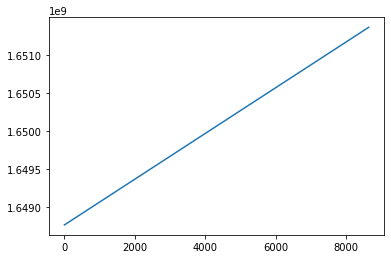

In [381]:
f['unix'].plot()

In [388]:
#verified with https://www.coindesk.com/price/bitcoin/
df = pd.read_csv('../data/price/BTC-USD-2022-04-01.csv')

df

,index,unix,low,high,open,close,volume,date,vol_fiat
0,0,1648771200,45425.41,45586.35,45525.25,45567.69,90.474085,2022-04-01 00:00:00,4.122695e+06
1,1,1648771500,45544.52,45613.34,45574.71,45613.34,54.535583,2022-04-01 00:05:00,2.487550e+06
2,2,1648771800,45541.81,45654.99,45612.27,45632.06,41.799105,2022-04-01 00:10:00,1.907379e+06
3,3,1648772100,45541.66,45638.93,45632.05,45588.42,48.694854,2022-04-01 00:15:00,2.219921e+06
4,4,1648772400,45560.46,45630.59,45588.42,45615.87,43.711797,2022-04-01 00:20:00,1.993952e+06
...,...,...,...,...,...,...,...,...,...
1435,1435,1649201700,45822.46,45892.84,45830.34,45871.94,26.761475,2022-04-05 23:35:00,1.227601e+06
1436,1436,1649202000,45754.63,45872.79,45871.42,45754.63,37.648727,2022-04-05 23:40:00,1.722604e+06
1437,1437,1649202300,45589.55,45766.99,45755.99,45610.23,103.834393,2022-04-05 23:45:00,4.735911e+06
1438,1438,1649202600,45371.16,45642.10,45607.83,45553.40,203.134434,2022-04-05 23:50:00,9.253464e+06
